# Определение перспективного тарифа для телеком-компании

Смоделируем аналитическую задачу для «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Необходимо проверить гипотезы:
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

**Описание данных**

Таблица users (информация о пользователях):

* user_id — уникальный идентификатор пользователя

* first_name — имя пользователя

* last_name — фамилия пользователя

* age — возраст пользователя (годы)

* reg_date — дата подключения тарифа (день, месяц, год)

* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)

* city — город проживания пользователя

* tariff — название тарифного плана

Таблица calls (информация о звонках):

* id — уникальный номер звонка

* call_date — дата звонка

* duration — длительность звонка в минутах

* user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):

* id — уникальный номер сообщения

* message_date — дата сообщения

* user_id — идентификатор пользователя, отправившего сообщение

* Таблица internet (информация об интернет-сессиях):

* id — уникальный номер сессии

* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)

* session_date — дата интернет-сессии

* user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):

* tariff_name — название тарифа

* rub_monthly_fee — ежемесячная абонентская плата в рублях

* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату

* messages_included — количество сообщений в месяц, включённых в абонентскую плату

* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)

* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)

* rub_per_message — стоимость отправки сообщения сверх тарифного пакета

* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета

## Изучение данных из файлов

In [1]:
# импортируем библиотеки
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from scipy import stats as st
from scipy.stats import mannwhitneyu
from scipy.stats import norm
import pingouin as pg
from urllib.parse import urlencode 
from tqdm.auto import tqdm
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

In [2]:
# открываем исходные файлы
df_calls = pd.read_csv('/Users/dmitrijvolgin/Downloads/Я_Практикум/Проекты/Статистический анализ данных/calls.csv')
df_internet = pd.read_csv('/Users/dmitrijvolgin/Downloads/Я_Практикум/Проекты/Статистический анализ данных/internet.csv',
                         index_col=0)
df_messages = pd.read_csv('/Users/dmitrijvolgin/Downloads/Я_Практикум/Проекты/Статистический анализ данных/messages.csv')
df_tariffs = pd.read_csv('//Users/dmitrijvolgin/Downloads/Я_Практикум/Проекты/Статистический анализ данных/tariffs.csv')
df_users = pd.read_csv('/Users/dmitrijvolgin/Downloads/Я_Практикум/Проекты/Статистический анализ данных/users.csv')

In [3]:
# изучаем исходные файлы
name = [df_calls, 
        df_users, 
        df_messages, 
        df_tariffs, 
        df_internet]
def info_df (row):
    for i in range(len(name)):
        name_str = ['df_calls', 
                'df_users', 
                'df_messages', 
                'df_tariffs', 
                'df_internet']
        print(name_str[i])
        print()
        name[i].info()
        display(name[i].head(10))
        display('Количество явных дубликатов =',name[i].duplicated().sum())
        print('Количество пропусков значений:','\n',name[i].isna().sum())
        print('###########################################################')
        print()
        
info_df(name)
   

df_calls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


'Количество явных дубликатов ='

0

Количество пропусков значений: 
 id           0
call_date    0
duration     0
user_id      0
dtype: int64
###########################################################

df_users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


'Количество явных дубликатов ='

0

Количество пропусков значений: 
 user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64
###########################################################

df_messages

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


'Количество явных дубликатов ='

0

Количество пропусков значений: 
 id              0
message_date    0
user_id         0
dtype: int64
###########################################################

df_tariffs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


'Количество явных дубликатов ='

0

Количество пропусков значений: 
 messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64
###########################################################

df_internet

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


'Количество явных дубликатов ='

0

Количество пропусков значений: 
 id              0
mb_used         0
session_date    0
user_id         0
dtype: int64
###########################################################



In [4]:
# проверяем столбец 'city' на неявные дубликаты
df_users['city'].unique() 

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

In [5]:
# Функция по для построения гистограммы и боксплота
def creating_box_hist(column, df):
    # создание фигуры, состоящей из двух(ax_box and ax_hist)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})    

    # присвоение графика каждому ax
    sns.boxplot(df[column], ax=ax_box)
    sns.histplot(data=df, x=column, ax=ax_hist)

    # Удалить имя оси x для boxplot
    ax_box.set(xlabel='')
    
    plt.show()

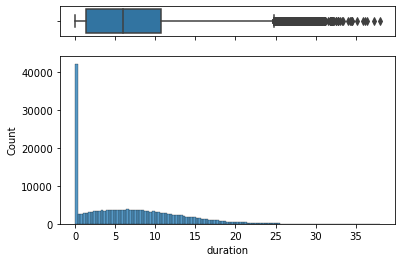

In [6]:
# рассмотрим распределение длительности звонков
creating_box_hist('duration', df_calls)

Видим распределение Фишера с большим хвостом выбросов в правой части.

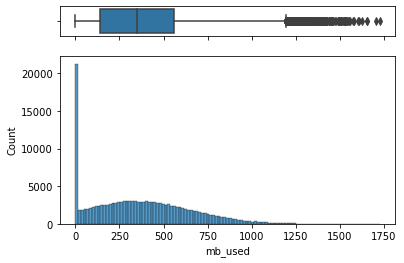

In [7]:
# рассмотрим распределение использованного трафика
creating_box_hist('mb_used', df_internet)

Видим распределение Фишера с большим хвостом выбросов в правой части.

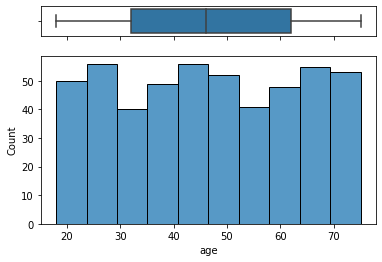

In [8]:
# рассмотрим распределение по возрасту
creating_box_hist('age', df_users)

### Вывод

В процессе изучения файлов было выявлено следующее:

* В файле "users.csv" в столбце "churn_date" 462 пропуска, но так как нам этот столбец не интересен, то мы оставим его без внимания.
* В всех файлах, кроме "users.csv", где есть дата нужно изменить тип данных с object на datetime64[ns]
* Рассмотрев распределения продолжительности звонков и использвонного интернет трафика, видно, что они отличны от нормального и похожи на распределения Фишера с большим хвостом выбросов.
* Распределение возраста клиентов достаточно равномерно.

## Подготовка данных

In [9]:
# Изменяем тип данных в столбцах, а также создаем новые столбцы и выделяем в них номер месяца    
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')
df_calls['month'] = df_calls['call_date'].dt.month
df_internet['month'] = df_internet['session_date'].dt.month
df_messages['month'] = df_messages['message_date'].dt.month
df_users['month'] = df_users['reg_date'].dt.month
df_users.info() 



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     object        
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
 8   month       500 non-null    int64         
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 35.3+ KB


In [10]:
# округляем значения столбца с длительностью звонка в соотвествии с условиями тарификации
print(df_calls['duration'].unique())
df_calls['duration'] = np.ceil(df_calls['duration'])
df_calls['duration'].unique()

[ 0.    2.85 13.8  ... 24.36 24.5  26.9 ]


array([ 0.,  3., 14.,  6., 19.,  8., 10.,  5., 13., 16.,  9.,  2., 15.,
       11., 24., 12., 23.,  7., 20.,  1.,  4., 17., 21., 18., 25., 22.,
       27., 26., 29., 28., 30., 37., 31., 33., 34., 32., 36., 35., 38.])

In [11]:
# группируем данные по звонкам
df_calls_pivot = df_calls.pivot_table(index=['user_id','month'], values='duration', aggfunc=['sum', 'count'])
df_calls_pivot = df_calls_pivot.reset_index()
df_calls_pivot.columns = ['user_id', 'month', 'sum_duration', 'count_duration']
display(df_calls_pivot.head())

,user_id,month,sum_duration,count_duration
0,1000,5,159.0,22
1,1000,6,172.0,43
2,1000,7,340.0,47
3,1000,8,408.0,52
4,1000,9,466.0,58


In [12]:
# группируем данные по использованному интернет-трафику
df_internet_pivot = df_internet.pivot_table(index=['user_id','month'], values='mb_used', aggfunc=['sum'])
df_internet_pivot = df_internet_pivot.reset_index()
df_internet_pivot.columns = ['user_id', 'month', 'gb_used']
display(df_internet_pivot.head())

,user_id,month,gb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


In [13]:
# переводим мегабайты в гигабайты и округляем в большую сторону в соотвествии с условиями тарификации
df_internet_pivot['gb_used'] = df_internet_pivot['gb_used'] / 1024
df_internet_pivot['gb_used'] = np.ceil(df_internet_pivot['gb_used'])

In [14]:
df_internet_pivot['gb_used']

0        3.0
1       23.0
2       14.0
3       14.0
4       15.0
        ... 
3198    21.0
3199     2.0
3200    18.0
3201    18.0
3202    13.0
Name: gb_used, Length: 3203, dtype: float64

In [15]:
# группируем данные по сообщениям
df_messages_pivot = df_messages.pivot_table(index=['user_id','month'], values='id', aggfunc=['count'])
df_messages_pivot = df_messages_pivot.reset_index()
df_messages_pivot.columns = ['user_id', 'month', 'count_messages']
display(df_messages_pivot.head())

,user_id,month,count_messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [16]:
# объединяем сгруппированные данные по звонкам,интернет-трафику, сообщениям в одну 
total = df_calls_pivot.merge(df_internet_pivot, on=['user_id','month'], how='outer') \
                      .merge(df_messages_pivot, on=['user_id','month'], how='outer')

display(total.head())

,user_id,month,sum_duration,count_duration,gb_used,count_messages
0,1000,5,159.0,22.0,3.0,22.0
1,1000,6,172.0,43.0,23.0,60.0
2,1000,7,340.0,47.0,14.0,75.0
3,1000,8,408.0,52.0,14.0,81.0
4,1000,9,466.0,58.0,15.0,57.0


In [17]:
# проверяем таблицу на пропуски
total.isna().sum()

user_id             0
month               0
sum_duration       40
count_duration     40
gb_used            11
count_messages    497
dtype: int64

In [18]:
# заменяем пропуски в таблице на 0, для дальнейших вычислений
total = total.fillna(0)  

In [19]:
total.isna().sum()

user_id           0
month             0
sum_duration      0
count_duration    0
gb_used           0
count_messages    0
dtype: int64

In [20]:
# добавляем в итогувую таблицу информацию по тарифу и городу
df_users_tariff = df_users[['user_id','tariff']]
df_users_city = df_users[['user_id','city']]
total = total.merge(df_users_tariff, on='user_id', how='left')
total = total.merge(df_users_city, on='user_id', how='left')
total.columns = ['user_id', 'month', 'calls_sum','calls_count', 'gb_used', 'count_messages', 'tariff', 'cityy']

In [21]:
total.head()

,user_id,month,calls_sum,calls_count,gb_used,count_messages,tariff,cityy
0,1000,5,159.0,22.0,3.0,22.0,ultra,Краснодар
1,1000,6,172.0,43.0,23.0,60.0,ultra,Краснодар
2,1000,7,340.0,47.0,14.0,75.0,ultra,Краснодар
3,1000,8,408.0,52.0,14.0,81.0,ultra,Краснодар
4,1000,9,466.0,58.0,15.0,57.0,ultra,Краснодар


In [22]:
# добавим в итогувую таблицу информацию по условиям тарифа, 
#для этого нужно заранее привести к общему наименованию столбец с информацией по названию тарифа.
df_tariffs.rename(columns={'tariff_name':'tariff'}, inplace=True)
total = total.merge(df_tariffs, on = 'tariff', how='outer')

In [23]:
total.head()

,user_id,month,calls_sum,calls_count,gb_used,count_messages,tariff,cityy,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,159.0,22.0,3.0,22.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1
1,1000,6,172.0,43.0,23.0,60.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1
2,1000,7,340.0,47.0,14.0,75.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1
3,1000,8,408.0,52.0,14.0,81.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1
4,1000,9,466.0,58.0,15.0,57.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1


In [24]:
# добавим всю информацию из total в df_users для дальнейшей работы
df_users = df_users.merge(total, on=['user_id','month','tariff'], how='outer')

In [25]:
# переведем информацию по включенным мегабайтам в тариф в гигабайты
df_users['mb_per_month_included'] = df_users['mb_per_month_included'] / 1024

In [26]:
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,calls_sum,...,gb_used,count_messages,cityy,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,159.0,...,3.0,22.0,Краснодар,1000.0,30.0,3000.0,1950.0,150.0,1.0,1.0
1,1001,41.0,NaN,Москва,Иван,Ежов,2018-11-01,smart,11,430.0,...,18.0,0.0,Москва,50.0,15.0,500.0,550.0,200.0,3.0,3.0
2,1002,59.0,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6,117.0,...,11.0,4.0,Стерлитамак,50.0,15.0,500.0,550.0,200.0,3.0,3.0
3,1003,23.0,NaN,Москва,Белла,Белякова,2018-08-17,ultra,8,380.0,...,9.0,37.0,Москва,1000.0,30.0,3000.0,1950.0,150.0,1.0,1.0
4,1004,68.0,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5,35.0,...,14.0,95.0,Новокузнецк,1000.0,30.0,3000.0,1950.0,150.0,1.0,1.0


In [27]:
# посчитаем выручку по звонкам, там где значение отрицатеьное считаем, 
#что пользователь уложился в тариф, поэтому прировняем отрицательные значения к нулю.
df_users['revenue_calls'] = (df_users['calls_sum'] - df_users['minutes_included']) * df_users['rub_per_minute']
df_users.loc[df_users['revenue_calls'] < 0, 'revenue_calls'] = 0

In [28]:
# посчитаем выручку по использованному трафику, там где значение отрицатеьное считаем, 
#что пользователь уложился в тариф, поэтому прировняем отрицательные значения к нулю.
df_users['revenue_internet'] = (df_users['gb_used'] - df_users['mb_per_month_included']) * df_users['rub_per_gb']
df_users.loc[df_users['revenue_internet'] < 0, 'revenue_internet'] = 0

In [29]:
# посчитаем выручку по сообщениям, там где значение отрицатеьное считаем, 
#что пользователь уложился в тариф, поэтому прировняем отрицательные значения к нулю.
df_users['revenue_message'] = (df_users['count_messages'] - df_users['messages_included']) * df_users['rub_per_message']
df_users.loc[df_users['revenue_message'] < 0, 'revenue_message'] = 0

In [30]:
# посчитаем итоговую выручку
df_users['revenue_total'] = (df_users['revenue_calls'] + 
                            df_users['revenue_internet'] + 
                            df_users['revenue_message'] + 
                            df_users['rub_monthly_fee'])

In [31]:
#проверим итогувую выручку на наличие пропусков
df_users.loc[df_users['revenue_total'].isna() == True]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,calls_sum,...,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue_calls,revenue_internet,revenue_message,revenue_total
128,1128,51.0,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
371,1371,50.0,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# Ввиду того, что два пользователя отлючились, через несколько дней после подключения к тарифу, мы видим, что выручки по ним нет.
# Поэтому мы их исключим из анализа.
df_users_good = df_users.loc[df_users['revenue_total'].isna() != True]

### Вывод

В процессе подготовки данных:
* Изменил тип данных с object на datetime64[ns] в небходимых столбцах.
* Добавил столбец с номером месяца.
* Округлил значения столбца с длительностью звонка в большую сторону в соотвествии с условиями тарификации.
* Перевел значения интернет-трафика из мегабайт в гигабайты и округлил в большую сторону в соотвествии с условиями тарификации. 
* Сгруппировал данные звонкам, интернет-трафику, сообщениеям по пользователю и месяцу.
* Все ранее сгруппированные данные объеденил в одну таблицу. В итоговой таблице были найдены пропуски, которые появились ввиду того, что абонент пользовался в конкретный месяц только частью услуг. Заменил пропуски на "0" для дальнейших вычислений.
* Добавил в итоговую таблицу информацию по условиям тарифа и городу проживания абонента.
* Объеденил итоговую таблицу с таблицей по абонентам и в новой таблице посчитал выручку от каждого абонента в разрезе месяца, услуг, а также общую выручку. Значения по выручке в разрезе услуг, которые получились меньше нуля расценил как факт того, что пользователь не израсходовал предоставленные лимиты в рамках тарифа и поэтому прировнял их к нулю.
* в итоговой таблице df_users были найдены и исключены из анализа 2 абонента, которые подключились к тарифу и отключились через 5 и 8 дней соотвественно. Ни абонентской платы, ни пользование тарифом не зафиксированно, поэтому и было принято решение искючить их из анализа.

В итоге получил таблицу со веми необходимыми данными для дальнейшего анализа.

## Анализ данных

In [33]:
# сделаем из итоговой таблицы два среза по тарифам
df_users_good_ultra = df_users_good.query('tariff == "ultra"')
df_users_good_smart = df_users_good.query('tariff == "smart"')
print(df_users_good_ultra.shape)
df_users_good_smart.shape

(985, 25)


(2229, 25)

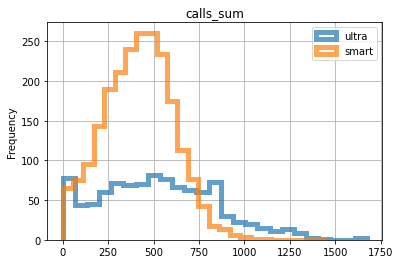

Среднее количество тарифа ultra = 526.6233502538071
Среднее количество тарифа smart = 417.9349484073576
Дисперсия тарифа ultra = 100873.63339730089
Дисперсия тарифа smart = 36219.31578434428
Стандартное отклонение тарифа ultra = 317.60609785912624
Стандартное отклонение тарифа smart = 190.31372988921288


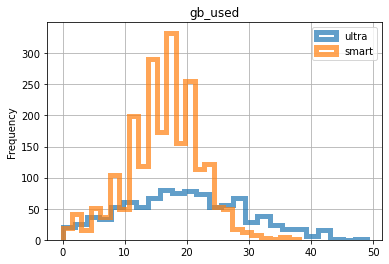

Среднее количество тарифа ultra = 19.494416243654822
Среднее количество тарифа smart = 16.328847016599372
Дисперсия тарифа ultra = 97.09168626965469
Дисперсия тарифа smart = 33.02870517811148
Стандартное отклонение тарифа ultra = 9.853511367510299
Стандартное отклонение тарифа smart = 5.747060568509043


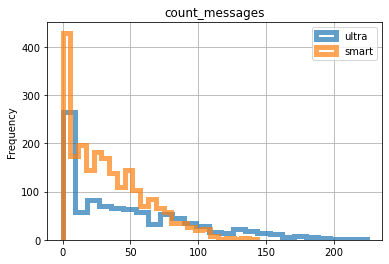

Среднее количество тарифа ultra = 49.36345177664975
Среднее количество тарифа smart = 33.384028712427096
Дисперсия тарифа ultra = 2285.266142544685
Дисперсия тарифа smart = 796.8129584480082
Стандартное отклонение тарифа ultra = 47.804457350174836
Стандартное отклонение тарифа smart = 28.227875556761408


In [34]:
# Посчитаем для услуг среднее количество, дисперсию, стандартное отклонение и построим гистограммы.
colomns = ['calls_sum','gb_used','count_messages']
for t in colomns:
    ax = df_users_good_ultra.plot(
    kind='hist',
    y=t,
    histtype='step',
    #range=(0, 2000),
    bins=25,
    linewidth=5,
    alpha=0.7,
    label='ultra',
    )
    df_users_good_smart.plot(
    kind='hist',
    y=t,
    histtype='step',
    #range=(0, 2000),
    bins=25,
    linewidth=5,
    alpha=0.7,
    label='smart',
    ax=ax,
    grid=True,
    legend=True,
    ) 
    plt.title(t)
    plt.show()
    print('Среднее количество тарифа ultra =',df_users_good_ultra[t].mean())
    print('Среднее количество тарифа smart =',df_users_good_smart[t].mean())
    print('Дисперсия тарифа ultra =', np.var(df_users_good_ultra[t], ddof=1))
    print('Дисперсия тарифа smart =', np.var(df_users_good_smart[t], ddof=1))
    print('Стандартное отклонение тарифа ultra =', np.std(df_users_good_ultra[t], ddof=1))
    print('Стандартное отклонение тарифа smart =', np.std(df_users_good_smart[t], ddof=1))
    

По гистограммам количества использованных минут и сообщений видно, что на тарифе smart большинство пользователей пытаются уложиться в предоставленный лимит, в то время как на тарифе ultra большинство не набирает даже половины предоставленного лимита. В части интернет-трафика ситуация немного отличается - видно, что пользователи активно поьзуются данной услугой и предоставленных лимитов на тарифе smart явно недостаточно и отношение пользователей, которые уложились в лимит и те, которые не уложились примерно 50% на 50%. На тарифе ultra ситуация немного иная, большинство пользователей все же уложились в лимит. Также стоит отметить, что на тарифе ultra дисперсия гараздо выше, что свидетельствует о неоднородности данных.

In [35]:
# проверим выручку по тарифу ultra на нормальность
st.normaltest(np.log(df_users_good_ultra['revenue_total']))

NormaltestResult(statistic=684.073717195422, pvalue=2.8528550318274956e-149)

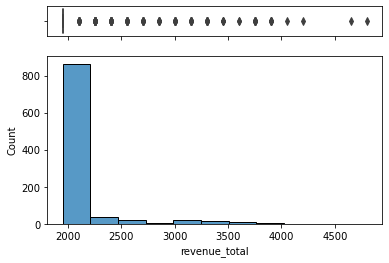

In [36]:
# рассмотрим гистограмму выручки по тарифу ultra
creating_box_hist('revenue_total', df_users_good_ultra)

<AxesSubplot:title={'center':'Q-Q Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

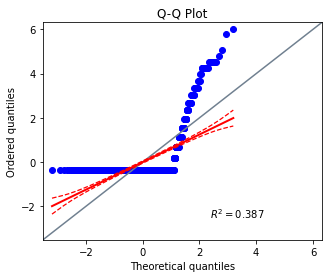

In [37]:
# проверим выручку по тарифу ultra на нормальность
pg.qqplot(np.log([df_users_good_ultra['revenue_total']]), dist='norm')

In [38]:
# проверим выручку по тарифу smart на нормальность
st.normaltest(np.log(df_users_good_smart['revenue_total']))

NormaltestResult(statistic=626.586200207106, pvalue=8.68031342274237e-137)

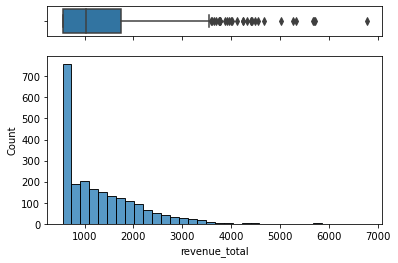

In [39]:
# рассмотрим гистограмму выручки по тарифу smart
creating_box_hist('revenue_total', df_users_good_smart)

<AxesSubplot:title={'center':'Q-Q Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

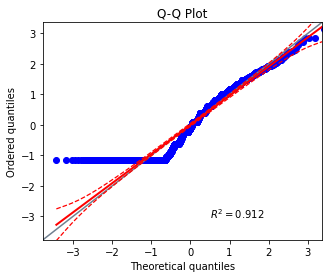

In [40]:
# проверим выручку по тарифу smart на нормальность
pg.qqplot(np.log(df_users_good_smart['revenue_total']), dist='norm')

### Вывод

В результате анализа количества минут разговора, сообщений и использованного интернет-трафика в разрезе двух тарифов можно сделать следующие выводы:
* все услуги для двух тарифов имеют нормальное распределение с положительной скошенностью.
* Разброс данных, а следовательно диспресия, среднее и стандартное отклонение для услуг тарифа ultra выше, чем у тарифа smart. Это видно и по гистограмме.
* По гистограммам количества использованных минут и сообщений видно, что на тарифе smart большинство пользователей пытаются уложиться в предоставленный лимит, в то время как на тарифе ultra большинство не набирает даже половины предоставленного лимита. В части интернет-трафика ситуация немного отличается - видно, что пользователи активно поьзуются данной услугой и предоставленных лимитов на тарифе smart явно недостаточно и отношение пользователей, которые уложились в лимит и те, которые не уложились примерно 50% на 50%. На тарифе ultra ситуация немного иная, большинство пользователей все же уложились в лимит.
* Рассмотрев распределения по выручке от каждого таоифа, видно, что они далеки от нормальных и с большой дисперсией, логарифмирование данных немного улучшает ситуацию, но глобально ничего не меняет. Данная картина связана с тем, что большинство пользователей либо укладываются в абонентскую плату по тарифу, либо незначительно превышают ее.


## Формулировка и проверка гипотез

У нас есть две гипотезы, сформулируем для них нулевую и алтернативную гипотезы:

**средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются:**
* $H_0$ - средняя выручка пользователей тарифов «Ультра» и «Смарт» равны.
* $H_1$ - средняя выручка пользователей тарифов «Ультра» и «Смарт» не равны.

**средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов:**
* $H_0$ - средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.
* $H_1$ - средняя выручка пользователей из Москвы не равна выручке пользователей из других регионов.

### Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

In [41]:
# функция bootstrap с визуализацией

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [42]:
# Проверим гипотезу - "средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются" с помощью ttest
alpha = .05
results = st.ttest_ind(
    np.log(df_users_good_ultra['revenue_total']), 
    np.log(df_users_good_smart['revenue_total']),
    equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
print()
print('ultra','\n', df_users_good_ultra['revenue_total'].describe())
df_users_good_smart['revenue_total'].describe()

p-значение:  0.0
Отвергаем нулевую гипотезу

ultra 
 count     985.000000
mean     2070.152284
std       376.187114
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: revenue_total, dtype: float64


count    2229.000000
mean     1289.973531
std       818.404367
min       550.000000
25%       550.000000
50%      1023.000000
75%      1750.000000
max      6770.000000
Name: revenue_total, dtype: float64

In [43]:
# Проверим гипотезу - "средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются" с помощью mannwhitneyu
mannwhitneyu(df_users_good_ultra['revenue_total'], 
             df_users_good_smart['revenue_total'])

MannwhitneyuResult(statistic=1796019.0, pvalue=1.9803845594554806e-187)

Критерий Манна-Уитни  также показал, что необходимо отклонить нулевую гипотезу, так как pvalue < 0.05.

  0%|          | 0/1000 [00:00<?, ?it/s]

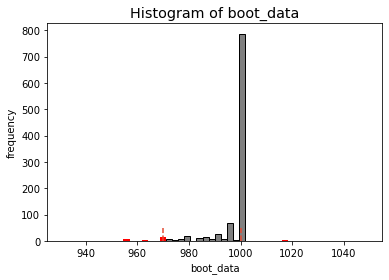

{'boot_data': [1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  983.0,
  1000.0,
  1000.0,
  979.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  997.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  997.0,
  988.0,
  994.0,
  1000.0,
  931.0,
  1000.0,
  987.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  992.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  997.0,
  1000.0,
  1000.0,
  1000.0,
  997.0,
  1000.0,
  997.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  940.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  995.0,
  1000.0,
  1000.0,
  970.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  974.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  977.0,
  1000.0,
  985.0,
  1000.0,
  985.0,
  1000.0,
  1000.0,
  1000.0,
  997.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.

In [44]:
# проверка гипотез с помощью bootstrap median уровень значимости 0.95

get_bootstrap(
    df_users_good_ultra['revenue_total'], # числовые значения первой выборки
    df_users_good_smart['revenue_total'], # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

bootstrap также показал, что необходимо отклонить нулевую гипотезу, так как 0 не входит в доверительный интервал.

### Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [45]:
# сделаем из итоговой таблицы два среза по городам
df_users_good_moscow = df_users_good.query('cityy == "Москва"')
df_users_good_regions = df_users_good.query('cityy != "Москва"')
print(df_users_good_moscow.shape)
df_users_good_regions.shape

(611, 25)


(2603, 25)

In [46]:
# Проверим гипотезу - "средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов."
alpha = .05
results = st.ttest_ind(
    np.log(df_users_good_moscow['revenue_total']), 
    np.log(df_users_good_regions['revenue_total']),
    equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
print()
print('moscow','\n', df_users_good_moscow['revenue_total'].describe())
df_users_good_regions['revenue_total'].describe()

p-значение:  0.26204868839218715
Не получилось отвергнуть нулевую гипотезу

moscow 
 count     611.000000
mean     1546.713584
std       752.088071
min       550.000000
25%       780.500000
50%      1750.000000
75%      1950.000000
max      5321.000000
Name: revenue_total, dtype: float64


count    2603.000000
mean     1524.936227
std       808.787752
min       550.000000
25%       750.000000
50%      1583.000000
75%      1950.000000
max      6770.000000
Name: revenue_total, dtype: float64

In [47]:
# Проверим гипотезу - "средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов." 
# с помощью mannwhitneyu
mannwhitneyu(df_users_good_moscow['revenue_total'], 
             df_users_good_regions['revenue_total'])

MannwhitneyuResult(statistic=813301.5, pvalue=0.37423394910366004)

Критерий Манна-Уитни  также показал, что необходимо принять нулевую гипотезу, так как pvalue > 0.05.

  0%|          | 0/1000 [00:00<?, ?it/s]

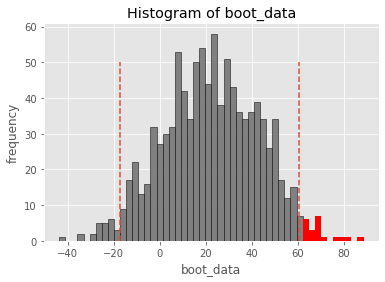

{'boot_data': [49.99577410679985,
  5.5155589704187475,
  32.50787552823665,
  8.19362274298886,
  21.598540145985403,
  6.262773722627737,
  69.32039953899347,
  19.393392239723397,
  16.185555128697658,
  30.689204763734153,
  47.72570111409912,
  5.884364195159431,
  32.379946215904724,
  60.653860929696506,
  -21.64733000384172,
  6.205147906262005,
  31.20169035728006,
  33.29504417979255,
  52.640030733768725,
  -0.44487130234344985,
  34.81482904341145,
  54.87552823665002,
  22.28275067230119,
  55.73953131002689,
  49.7245485977718,
  28.187091817134075,
  52.68190549366116,
  36.94429504417979,
  44.9366116019977,
  22.24010756819055,
  7.606607760276604,
  3.2082212831348444,
  16.2992700729927,
  23.310411064156742,
  25.876680752977332,
  26.349980791394543,
  50.08912792931233,
  17.75105647330004,
  -9.33691893968498,
  45.3703419131771,
  15.619285439877064,
  28.920860545524395,
  18.04955820207453,
  16.556281213983866,
  12.295812524010756,
  53.47637341529005,
  15.

In [48]:
# проверка гипотез с помощью bootstrap median уровень значимости 0.95

get_bootstrap(
    df_users_good_moscow['revenue_total'], # числовые значения первой выборки
    df_users_good_regions['revenue_total'], # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

bootstrap также показал, что необходимо принять нулевую гипотезу, так как 0 входит в доверительный интервал.

### Вывод

У нас есть две гипотезы, сформулируем для них нулевую и алтернативную гипотезы:

**средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются:**
* $H_0$ - средняя выручка пользователей тарифов «Ультра» и «Смарт» равны.
* $H_1$ - средняя выручка пользователей тарифов «Ультра» и «Смарт» не равны.

**средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов:**
* $H_0$ - средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.
* $H_1$ - средняя выручка пользователей из Москвы не равна выручке пользователей из других регионов.

Для проверки гипотез использовали t-критерий Стьюдента, критерий Манна-Уитни и bootstrap. Пороговое значение для p-value определим как 5%, ввиду того, что в данном исследовании сверхточность не требуется. Все они показали одиниковые результаты, поэтому принимаем следующие гипотезы:

**средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются:**
* $H_1$ - средняя выручка пользователей тарифов «Ультра» и «Смарт» не равны.

**средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов:**
* $H_0$ - средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.


## Общий вывод

В результате исследования удалось статистически подтвердить, что средняя выручка тарифа «Ультра» отличается от средней выручки тарифа «Смарт» в большую сторону, а предоставленные лимиты по тарифу «Ультра» редко используются полностью и даже наполовину. Ввиду доступности среди абонентов более популярен тариф «Смарт», но если получится привлечь в тариф «Ультра» дополнительных абонентов, то это принесет свои плоды ввиде выручки. Поэтому считаю логичным основные усилия направить именно на развитие тарифа «Ультра».

Ввиду того, что статистически удалась подтвердить гипотезу о том, что выручка пользователей из Москвы равна выручке пользователей из других регионов, идею по развитию тарифа «Ультра» можно применять на всю РФ.
